In [228]:
# !pip install umap-learn

In [1]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn

import datasets
from transformers import AutoTokenizer

import umap

In [2]:
dataset = datasets.load_dataset('bookcorpus')['train']
dataset[:3]

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for bookcorpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bookcorpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


{'text': ['usually , he would be tearing around the living room , playing with his toys .',
  'but just one look at a minion sent him practically catatonic .',
  "that had been megan 's plan when she got him dressed earlier ."]}

In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [189]:
# import model.rotator_lima3 as rotator
# subpath = '20240422.11:52:35-batch_size_1024'

# import model.rotator_multihead_local_coordinate as rotator
# subpath = '20240422.02:23:48-batch_size_1024'
# batch_num = 10000

import model.rotator_multireslima_rotating_history as rotator
subpath = '20240422.02:12:51-batch_size_1024'
subpath = '20240424.00:15:13-batch_size_1024' #rotator_lima3, triplet loss
subpath = '20240430.16:16:30-batch_size_256' # rotator_lima4_hippo, mse+multiplet, dim128, hdim32, head32, dep3
subpath = '20240502.19:17:09-batch_size_512'
subpath = '20240502.21:10:49-batch_size_64' # rotator_lima4_noClocks, msmarco, mse+multiplet, dim128, hdim32, head32, dep3
subpath = '20240502.23:36:34-batch_size_512' # noTime, cos_dist+multiplet

# subpath = '20240618.13:45:57'
# subpath = '20240618.17:32:36' #lima5_no_hippo, randn init embedding, lr0.01
# subpath = '20240618.18:45:47' #lima5_no_hippo, randn init embedding, lr0.0001
# subpath = '20240618.19:30:10' # lima5_no_hippo_xavier, lr0.01
# subpath = '20240618.19:51:52' # lima5_no_hippo_xavier, lr0.001
# subpath = '20240619.02:40:48' # lima6_randnInit, lr0.001
# subpath = '20240619.04:22:03' # lima6
# subpath = '20240619.10:06:59' # lima5
# subpath = '20240619.13:19:54' # lima6, dynamic scale
# subpath = '20240620.02:18:52' # lima6, dynamic scale
# subpath = '20240621.10:13:15' # lima7
# subpath = '20240621.10:17:31' # lima7_gru
# subpath = '20240621.13:18:59' # lima7_gru, CrossEntropyLoss
# subpath = '20240621.16:38:47' # lima7_gru_randInit
# subpath = '20240621.17:36:43' # lima7_gru, Cross_entropy_l2_embedding ***
# subpath = '20240621.17:57:55' # lima7, Cross_entropy_l2_embedding(model.model, l2_squared_weight=1e-2), lr0.005
# subpath = '20240621.18:18:59' # lima7_gru, Cross_entropy_l2_embedding(model.model, l2_squared_weight=1e-1), lr0.005
# subpath = '20240622.02:23:27' # lima7_gru, Cross_entropy_l2_embedding(model.model, l2_squared_weight=1e-3), lr0.005
# subpath = '20240622.02:24:23' # lima7_gru_randInit, Cross_entropy_l2_embedding(model.model, l2_squared_weight=1e-3), lr0.005
# subpath = '20240622.03:41:40' # lima7_gru_mixInit, Cross_entropy_l2_embedding(model.model, l2_squared_weight=1e-3), lr0.005
subpath = '20240622.05:16:52' # 4
# subpath = '20240622.06:42:05' # 5
# subpath = '20240622.06:50:40' # 6
subpath = '20240622.12:38:37' # 4 lima7_mixInit, higher lr, mixInit, AdamW
subpath = '20240622.16:50:54' # 5 lima8, AdamW
subpath = '20240622.17:20:54' # 6 lima8, scaled init
subpath = '20240622.17:51:02' # 7 lima8, more xavier
subpath = '20240623.14:51:34' # 4 lima8, sampled_softmax_cross_entropy, lr0.02
subpath = '20240623.15:36:29' # 5 lima8, sampled_softmax_cross_entropy, lr0.005
# subpath = '20240623.15:45:02' # 6 lima8, sampled_softmax_cross_entropy, lr0.005, randInit
subpath = '20240623.17:25:38' # 7 lima8, lr0.02
subpath = '20240623.18:32:21' # 4 lima8_perToken, lr0.01
subpath = '20240624.06:20:31' # 5 lima8_perToken, lr0.005
# subpath = '20240624.07:04:03' # 4 lima8_perToken, lr0.01, 
subpath = '20240624.09:58:53' # 6
subpath = '20240624.12:08:14' # 4 lima8_perToken, ssm_ce_with_bias
subpath = '20240624.14:02:39' # 5 lima8, ssm_ce_with_bias
subpath = '20240624.16:42:08' # 7 lima8, wiki
# subpath = '20240624.20:32:15' # 6 lima8_perToken, wiki
subpath = '20240625.10:17:52' # 4 train wiki on '20240624.12:08:14'batch-
# subpath = '20240625.11:39:15' # train wiki on '20240624.12:08:14'batch-20000
subpath = '20240626.09:08:18' # 4 train wiki on '20240624.12:08:14'batch-25000
subpath = '20240626.09:43:48' # 5 train wiki on '20240624.12:08:14'batch-20000

subpath = '20240704.20:55:54' # 4 abs_bert, bookcorpus
# subpath = '20240704.21:19:36' # 5 abs_bert, wiki
# subpath = '20240704.21:26:11' # 6 abs_bert, bookcorpus, xavier_init_embedding
# subpath = '20240704.21:33:23' # 7 abs_bert, wiki, xavier_init_embedding

batch_num = 100000

weight norms, min: 6.460202217102051, max: 24.081260681152344
min norms: ['[unused334]', '[MASK]', '##54', 'inception', '##¹', '39th', '[unused574]', '##rland', 'abuses', 'periodicals']
max norms: ['was', 'and', 'a', 'of', 'the', 'i', ',', '`', "'", '.']
bias norms, min: -0.0010086019756272435, max: 0.008460779674351215
min norms: ['shocks', 'donnelly', '2001', '[unused629]', 'ث', 'savoy', 'turbo', '##edo', '##−1', 'libel']
max norms: ['she', 'her', 'he', '?', 'it', 'was', 'of', '`', 'and', 'i']


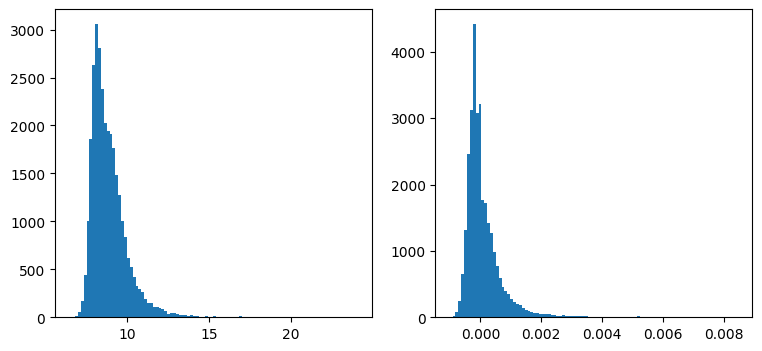

In [190]:
folder_path = pathlib.Path('data/limanet/')

# RNN = torch.load(folder_path/subpath/f'batch_{batch_num}-model.pt', map_location='cpu')
model = torch.load(folder_path/subpath/f'batch_{batch_num}-model.pt', map_location='cpu')
# model = RNN
# model = RNN.model

# epoch_num = 0
# RNN = torch.load(folder_path/subpath/f'epoch_{epoch_num}-model.pt', map_location='cpu')

# word_reprs_complex = model.predictor.all_word_embeddings()
# word_reprs = torch.concat([word_reprs_complex.real, word_reprs_complex.imag], dim=-1).detach().numpy()
word_reprs = model.word_embeddings().detach()

_, (ax_w, ax_b) = plt.subplots(1, 2, figsize=[9, 4])

# weight stats
norms = np.linalg.norm(word_reprs, axis=1)
indices = norms.argsort()
print(f"weight norms, min: {norms.min()}, max: {norms.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
_ = ax_w.hist(norms, bins=100)

# bias stats
biases = RNN.bias.detach()
indices = biases.argsort()
print(f"bias norms, min: {biases.min()}, max: {biases.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
if hasattr(model, 'predictor') and hasattr(model.predictor, 'base_vec'):
  print(f"base vec norm: {model.predictor.base_vec.norm()}")
_ = ax_b.hist(biases, bins=100)

In [191]:
%time
def get_projection(representations, n_neighbors=10, methods=['euclidean', 'cosine'], n_jobs=16):
    transed_repr = {}
    for method in methods:
        reducer = umap.UMAP(n_neighbors=n_neighbors, metric=method, n_jobs=n_jobs)
        transed_repr[method] = reducer.fit_transform(representations)
    return transed_repr

# complex_word_repr = model.predictor.all_word_embeddings()
# word_reprs = torch.concat([complex_word_repr.real, complex_word_repr.imag], dim=-1).detach()
# word_reprs = word_reprs.numpy()

# angle_reprs = model.angle_embedding.weight.detach().numpy()

transed_word = get_projection(word_reprs)
# transed_angle = get_projection(angle_repr)

# del model

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 29.1 µs


In [192]:
vector_norms = np.linalg.norm(word_reprs, axis=1)
# angle_norms = np.linalg.norm(angle_reprs, axis=1)

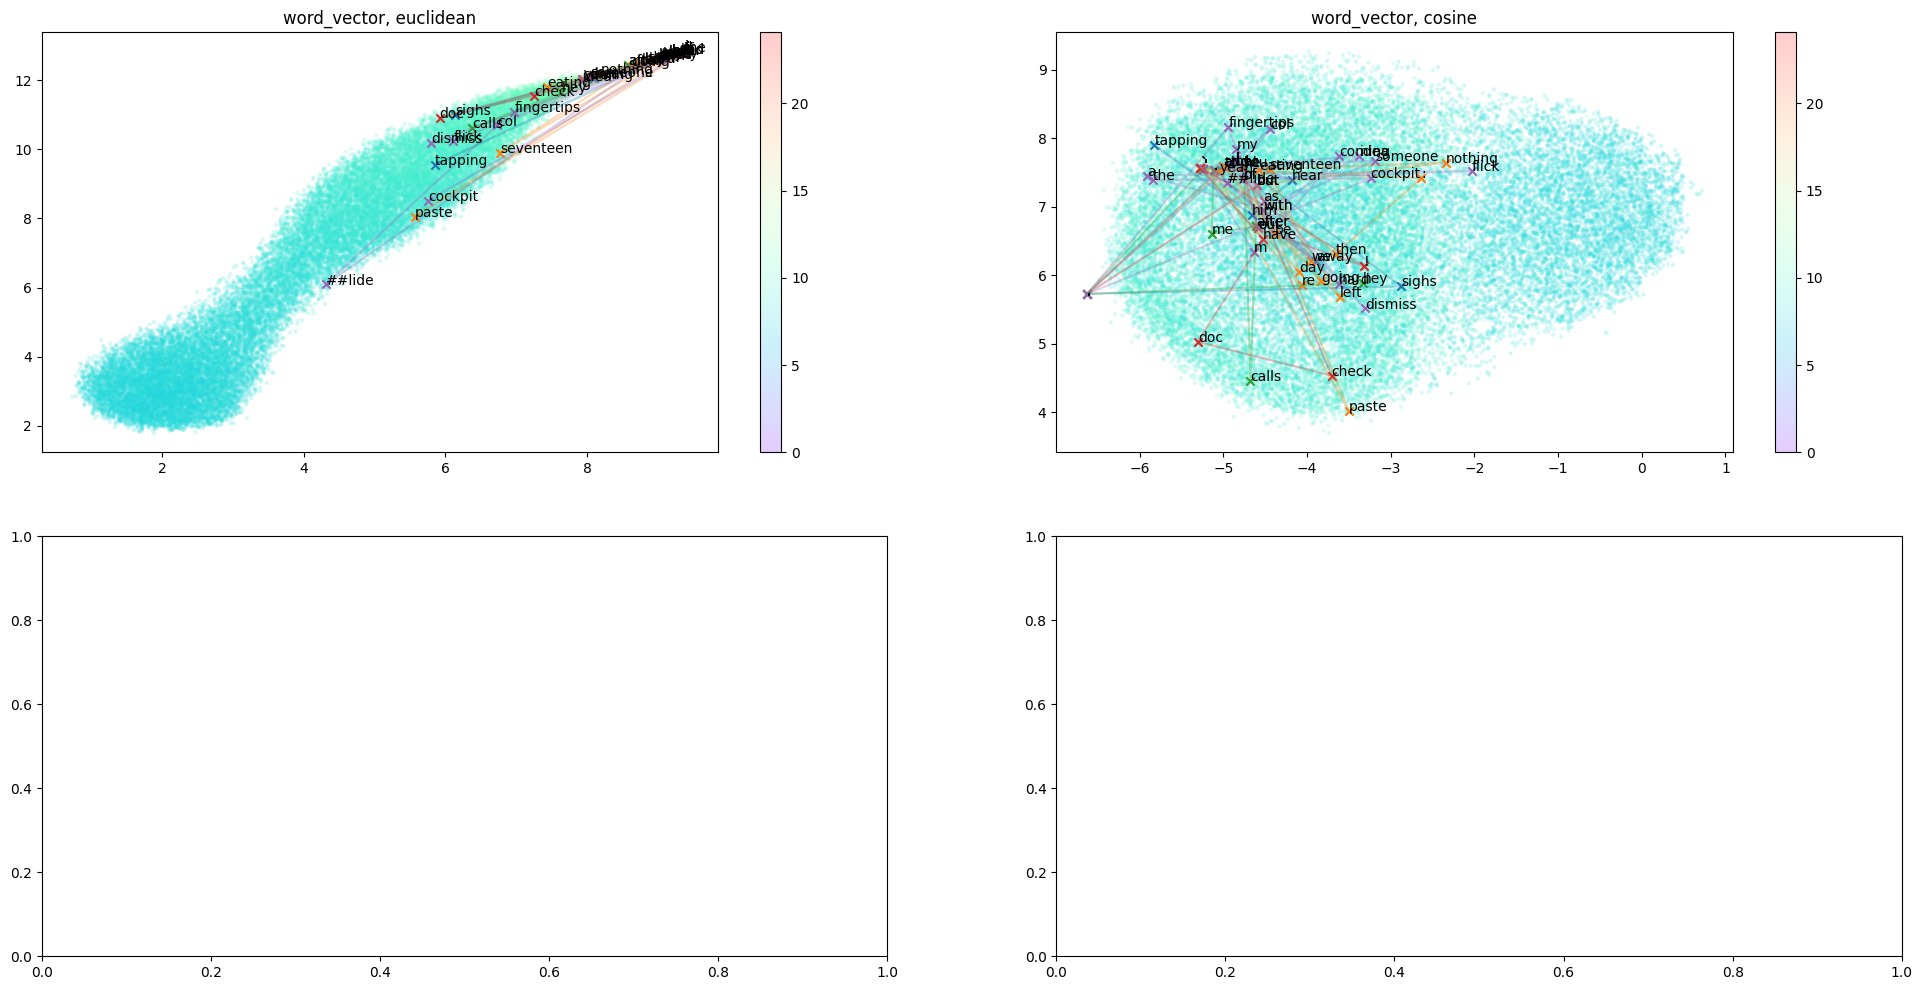

In [193]:
sampling_position = np.random.randint(0, len(dataset))


samples = dataset[sampling_position:sampling_position+5]['text']
sequences = tokenizer(samples, add_special_tokens=False)['input_ids']

representations = {
    'word_vector': (transed_word, vector_norms),
    # 'word_angle': (transed_angle, angle_norms)
}
methods = ['euclidean', 'cosine']



fig, axes = plt.subplots(len(methods), max(2, len(representations)), figsize=[12*len(methods),12*len(representations)])
cmap = plt.get_cmap('rainbow')
for i, repr_name in enumerate(representations):
    for j, method in enumerate(methods):
        ax = axes[i, j]
        representation, norms = representations[repr_name]
        
        ax.set_title(f'{repr_name}, {method}')
        
        image = ax.scatter(*representation[method].T, marker='.', edgecolors='none', cmap=cmap, c=norms, alpha=.2, vmin=0)
        fig.colorbar(image, cmap=cmap, ax=ax)
      
        for seq in sequences:
            positions = representation[method][seq]
            ax.plot(*positions.T, alpha=.3)
            ax.scatter(*positions.T, marker='x')
            
            tokens = tokenizer.convert_ids_to_tokens(seq)
            
            for token, pos in zip(tokens, positions):
                # print(token, pos)
                ax.annotate(token, pos)

In [194]:
fig.savefig(f'image/umap-{subpath}_{batch_num}.png')

In [1507]:
# shuffle = False

# class Trainloader:
#   def __init__(self, dataset, batch_size):
#     self.data = dataset
#     self.batch_size = batch_size

#   def __len__(self):
#     return len(self.data) // batch_size + 1

#   def __iter__(self):
#     current_start = 0
#     for i in range(self.__len__()):
#       yield self.data[current_start:current_start+self.batch_size]
#       current_start += self.batch_size

# # train_dataloader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate)
# train_loader = Trainloader((dataset.shuffle() if shuffle else dataset)['train'], batch_size=batch_size)


# n = next(iter(train_loader))
# # print(tokenizer.decode(n['data']))
# {key: n[key].shape for key in n}

In [1508]:
# his = model.initial_states()['histories'][0].expand(data.shape[0], -1, -1)
# data = batch['data'][batch['batch_sizes']]
# lima = model.limas[0]
# theta = model.angle_embedding(data)

# output, next_history = lima(theta, his)
# # output

In [1509]:
# theta = torch.ones_like(theta)

In [1510]:
# batch_size = theta.shape[0]
# total_in = torch.concat([theta[:, None, :].expand(-1, lima.num_heads, -1), his], dim=-1).view(batch_size, -1)

In [1511]:
# h = lima.fc_in(total_in)
# h

In [655]:
from sklearn.decomposition import PCA

In [656]:
word_pca.shape

(30522, 256)

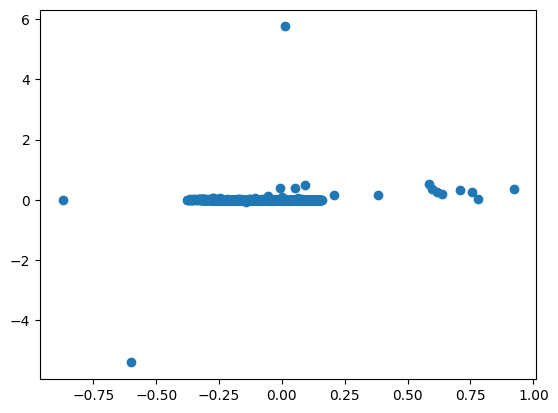

In [659]:
pca = PCA()
word_pca = pca.fit_transform(word_reprs)

i=0
plt.scatter(*word_pca.T[i*2:i*2+2])

(0.5839399, 1.3599438e-10)

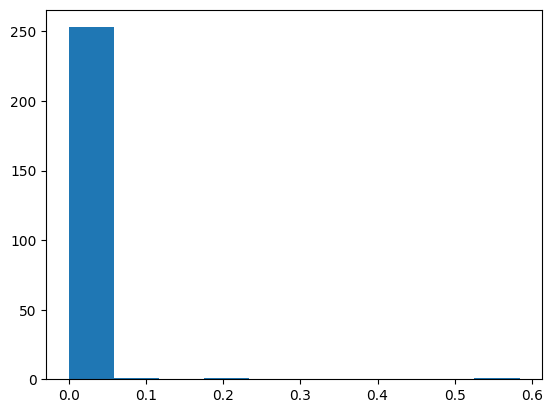

In [663]:
_ = plt.hist(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.max(), pca.explained_variance_ratio_.min()

In [ ]:
import utils.load_corpus as load_corpus
import importlib
load_corpus = importlib.reload(load_corpus)

dataset = load_corpus.load_bookcorpus(tokenizer, cache_dir='~/data1-0756727/cache/huggingface')
# dataset = load_corpus.load_msmarco(tokenizer, cache_dir='~/data1-0756727/cache/huggingface')

dataset['train'][:2]

In [ ]:
batch_size = 32
shuffle = False

class Trainloader:
  def __init__(self, dataset, batch_size):
    self.data = dataset
    self.batch_size = batch_size

  def __len__(self):
    return len(self.data) // batch_size + 1

  def __iter__(self):
    current_start = 0
    for i in range(self.__len__()):
      yield self.data[current_start:current_start+self.batch_size]
      current_start += self.batch_size

# train_dataloader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate)
train_loader = Trainloader((dataset.shuffle() if shuffle else dataset)['train'], batch_size=batch_size)


batch = next(iter(train_loader))
# print(tokenizer.decode(n['data']))
{key: batch[key].shape for key in n}

In [ ]:
his = model.initial_states()
data = batch['data'][batch['batch_sizes']]
theta = model.angle_embedding(data)
output, next_history = model.limas[0](theta, his['histories'][0].expand(data.shape[0], -1, -1))
output

In [458]:
fig.savefig(f'image/umap-{subpath}.png')

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

proj = PCA().fit_transform(word_repr)
plt.scatter(*proj.T[:2])

norm = np.linalg.norm(word_repr, axis=1)
print(norm.min(), norm.max())
tokenizer.convert_ids_to_tokens(proj.T[:2].argmax(axis=1))

In [ ]:
n = 100

sorted_norm_idx = norm.argsort()
print('mins:', *zip(norm[sorted_norm_idx[:n]], tokenizer.convert_ids_to_tokens(sorted_norm_idx[:n])))
print()
print('maxs:', *zip(norm[sorted_norm_idx[:-n-1:-1]], tokenizer.convert_ids_to_tokens(sorted_norm_idx[:-n-1:-1])))

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

proj = PCA().fit_transform(angle_repr)
plt.scatter(*proj.T[:2])

norm = np.linalg.norm(word_repr, axis=1)
print(norm.min(), norm.max())
tokenizer.convert_ids_to_tokens(proj.T[:2].argmax(axis=1))

In [ ]:
from transformers import AutoModel

In [ ]:
m = AutoModel.from_pretrained('bert-base-uncased')

In [ ]:
m